In [47]:
# STACKED PAIR MAP

Stacking galaxies:   0%|          | 0/13098 [00:00<?, ?it/s]

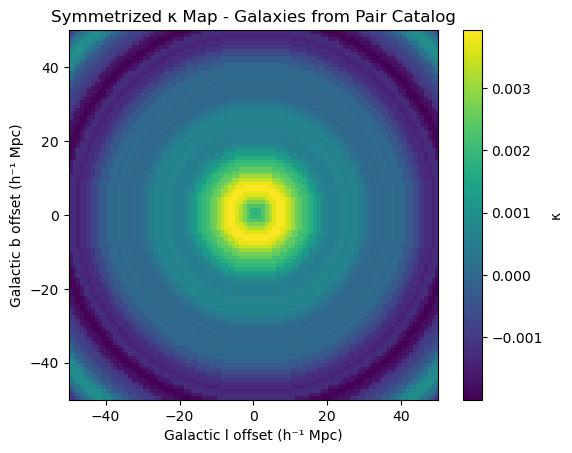

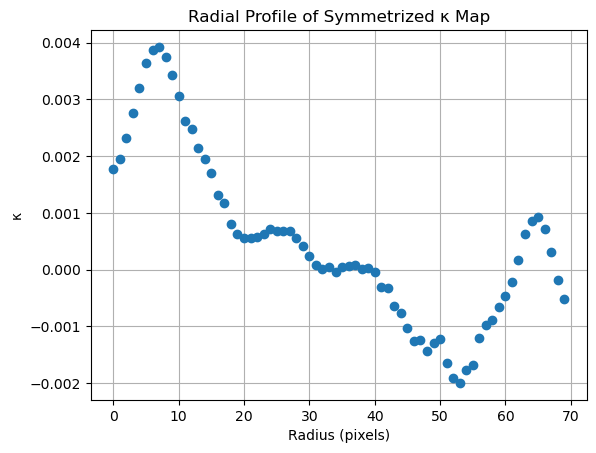

array([ 1.78038217e-03,  1.94180697e-03,  2.32787919e-03,  2.76950549e-03,
        3.20319371e-03,  3.63646823e-03,  3.87623862e-03,  3.92647460e-03,
        3.74521855e-03,  3.42799346e-03,  3.06964707e-03,  2.62704928e-03,
        2.47806503e-03,  2.13759603e-03,  1.94273838e-03,  1.70468853e-03,
        1.31638743e-03,  1.17096373e-03,  7.98931347e-04,  6.20074297e-04,
        5.58200608e-04,  5.63181281e-04,  5.66400992e-04,  6.21325553e-04,
        7.22240228e-04,  6.75918687e-04,  6.76488159e-04,  6.88493199e-04,
        5.59887799e-04,  4.23640161e-04,  2.41172929e-04,  8.12791974e-05,
        7.44073698e-06,  3.80917240e-05, -4.60960313e-05,  4.35434655e-05,
        5.43363545e-05,  8.16933888e-05,  1.76130236e-06,  2.75873259e-05,
       -3.93511338e-05, -3.15493537e-04, -3.24233729e-04, -6.49658806e-04,
       -7.62611628e-04, -1.03595392e-03, -1.25788141e-03, -1.24578207e-03,
       -1.43733269e-03, -1.29967218e-03, -1.22383466e-03, -1.64255934e-03,
       -1.90608754e-03, -

In [52]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import pandas as pd

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/galaxy_pairs_catalog.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.concatenate([pairs['l1'], pairs['l2']]) # degrees
b_all = np.concatenate([pairs['b1'], pairs['b2']]) # degrees
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value  # Mpc/h

weights = np.ones(len(l_all))  # equal weights

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")


Stacking galaxies:   0%|          | 0/100000 [00:00<?, ?it/s]

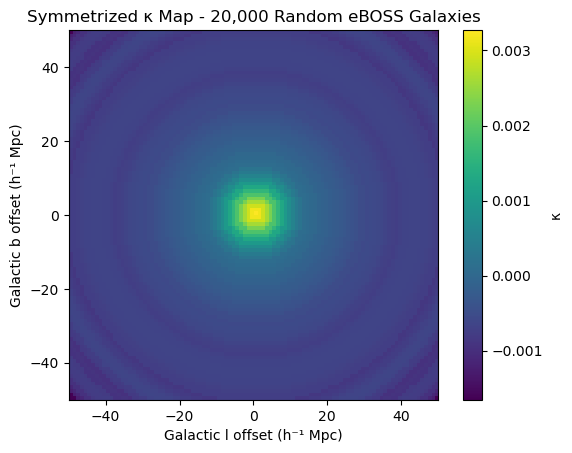

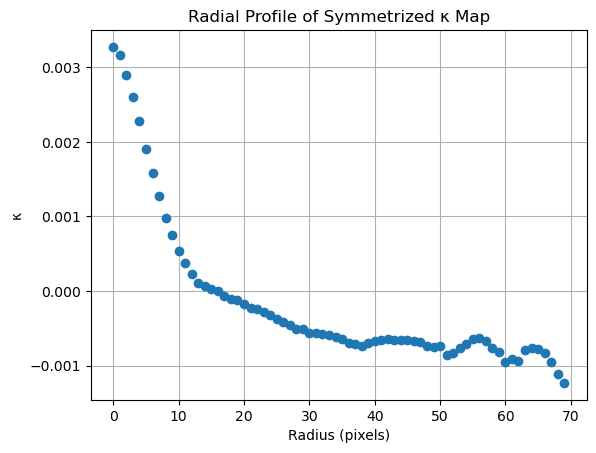

array([ 3.27145805e-03,  3.16270204e-03,  2.90111439e-03,  2.59870139e-03,
        2.28449825e-03,  1.89762895e-03,  1.57823405e-03,  1.27435419e-03,
        9.85649038e-04,  7.51872897e-04,  5.42167891e-04,  3.76360985e-04,
        2.31660675e-04,  1.15120461e-04,  6.76526221e-05,  2.25008065e-05,
        5.11645419e-06, -5.91325303e-05, -1.04676784e-04, -1.22547334e-04,
       -1.76324789e-04, -2.28223097e-04, -2.40618494e-04, -2.80249091e-04,
       -3.16036298e-04, -3.78462498e-04, -4.09940003e-04, -4.59033549e-04,
       -5.02629697e-04, -5.11602902e-04, -5.59435573e-04, -5.54944103e-04,
       -5.75557181e-04, -5.82376407e-04, -6.08759918e-04, -6.44587325e-04,
       -6.95820505e-04, -7.12383970e-04, -7.39836742e-04, -7.01026994e-04,
       -6.69122625e-04, -6.54247256e-04, -6.40658613e-04, -6.49320899e-04,
       -6.53152186e-04, -6.56860730e-04, -6.70378528e-04, -6.83986728e-04,
       -7.30795045e-04, -7.47245891e-04, -7.34909670e-04, -8.50584546e-04,
       -8.23159256e-04, -

In [53]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

def fast_icrs_to_galactic(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    R = np.array([
        [-0.0548755604, -0.8734370902, -0.4838350155],
        [ 0.4941094279, -0.4448296300,  0.7469822445],
        [-0.8676661490, -0.1980763734,  0.4559837762]
    ])
    xg, yg, zg = np.dot(R, np.array([x, y, z]))
    b_rad = np.arcsin(zg)
    l_rad = np.arctan2(yg, xg)
    l_deg = np.degrees(l_rad) % 360
    b_deg = np.degrees(b_rad)
    return l_deg, b_deg

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

# --- Select 100,000 random galaxies ---
num_random = 100000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 100,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")